<a href="https://colab.research.google.com/github/Carlosrnes/Nova_NLP/blob/main/NLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fac03db3-b1eb-3fed-7701-0fb69be2dbac)


In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-05-23 08:53:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-23 08:53:51 (38.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

### Libraries

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

### Get the data

In [5]:
train_df = pd.read_csv("training_set.txt", sep="\t")
test_df = pd.read_csv("dev_set.txt", sep="\t")
train_df.head()

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


### Explore Dataset

In [6]:
# How many examples of each class?
train_df.emotion.value_counts()

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [7]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 14000
Total test samples: 1000
Total samples: 15000


### Split data into training and validation sets

In [8]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["sentence"].to_numpy(),
                                                                            train_df["emotion"].to_numpy(),
                                                                            test_size=0.1, # 10% of samples
                                                                            random_state=42) # random state for reproducibility

# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(12600, 12600, 1400, 1400)

### Tokenization

In [9]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary 
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be

In [10]:
# Find average number of tokens (words) in training set
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

9

In [11]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 9 # max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [12]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [13]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 7270
Top 5 most common words: ['', '[UNK]', 'you', 'i', 'the']
Bottom 5 least common words: ['14', '129', '11th', '10', '000']


In [14]:
# Test out text vectorizer
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
If he breaks the law and it crosses this desk , he pays for it .

Length of text: 16

Vectorized text:
[[  40   32 6865    4  548    7    9 3231   15]]


In [15]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 10000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 9,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Embedding

In [16]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [17]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
If he breaks the law and it crosses this desk , he pays for it .

Sentence after vectorization (before embedding):
[[  40   32 6865    4  548    7    9 3231   15]]

Sentence after embedding:
[[[-0.04811442  0.04142534  0.00805675 ... -0.04650271 -0.03631166
   -0.00753704]
  [-0.01501486  0.01257223 -0.0458413  ... -0.01172409 -0.04809066
    0.00804969]
  [ 0.02232539  0.04376132 -0.04229261 ...  0.02910444  0.02517064
    0.03753917]
  ...
  [-0.03048784  0.04003957  0.01426423 ...  0.04380543 -0.01184901
    0.04811785]
  [ 0.02946473 -0.04284643 -0.02758916 ... -0.01993028  0.00943841
   -0.03477542]
  [ 0.04266793  0.03783042 -0.0123207  ... -0.02365079 -0.00954125
   -0.01112708]]]

Embedded sentence shape: (1, 9, 128)


In [18]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [19]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [20]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

### Create Models

In [21]:
# Function to evaluate: accuracy, precision, recall, f1-score

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

#### Model 0 - Baseline

In [22]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 32.29%


In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 8, 2, 8, 1, 8, 8, 1, 1, 1, 5, 1, 2, 2, 2, 1, 1, 2, 1])

In [25]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 32.285714285714285,
 'f1': 0.2598823619459004,
 'precision': 0.4933891627177566,
 'recall': 0.32285714285714284}

#### Model 1 - A simple dense model

In [26]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(8, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [27]:
# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [28]:
# Get a summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 9, 128)            1280000   
                                                                 
 conv1d (Conv1D)             (None, 9, 64)             41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 520   

In [29]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset))) 

Epoch 1/3
394/394 [==============================] - 18s 10ms/step - loss: 1.9284 - accuracy: 0.2606 - val_loss: 1.7901 - val_accuracy: 0.3250
Epoch 2/3
394/394 [==============================] - 4s 9ms/step - loss: 1.5679 - accuracy: 0.4370 - val_loss: 1.7668 - val_accuracy: 0.3636
Epoch 3/3
394/394 [==============================] - 3s 8ms/step - loss: 1.2655 - accuracy: 0.5656 - val_loss: 1.8754 - val_accuracy: 0.3593


In [30]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

44/44 [==============================] - 0s 3ms/step - loss: 1.8754 - accuracy: 0.3593


[1.8754218816757202, 0.35928571224212646]

In [31]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[0.6095116 , 0.09103049, 0.06265556, ..., 0.07059664, 0.01809467,
        0.09213438],
       [0.01184228, 0.10178211, 0.00582773, ..., 0.02756708, 0.03517227,
        0.11222605],
       [0.01680982, 0.04485427, 0.00400232, ..., 0.01053754, 0.00311318,
        0.6918775 ],
       ...,
       [0.3191495 , 0.00550976, 0.14167859, ..., 0.15688516, 0.13492252,
        0.06201799],
       [0.28512737, 0.03823321, 0.10831819, ..., 0.34042558, 0.01562743,
        0.11892038],
       [0.43609625, 0.00462792, 0.20659614, ..., 0.14680777, 0.08910385,
        0.0262713 ]], dtype=float32)

In [32]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) + 1
model_1_preds

<tf.Tensor: shape=(1400,), dtype=int64, numpy=array([1, 5, 8, ..., 1, 6, 1])>

In [33]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 35.92857142857142,
 'f1': 0.35503562211667233,
 'precision': 0.35611563514967365,
 'recall': 0.35928571428571426}

#### Model 2 - Feature extraction with pretrained token embeddings - Universal Sentence Encoder

In [34]:
# Download pretrained TensorFlow Hub universal sentence encoder

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [35]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
I just know it .

Sentence after embedding:
[ 0.04587783  0.04544145 -0.03478712  0.02554332  0.08167633 -0.03044202
 -0.01279072  0.00848574  0.08536546  0.05794521  0.04544753 -0.02391043
  0.02630072  0.00191605 -0.00070481 -0.04789066  0.03614861  0.02973003
  0.03372576 -0.0226154  -0.04442434 -0.0494564   0.01719003  0.0693833
 -0.01015351  0.02648278 -0.05226925 -0.01583186 -0.03185368 -0.05949975] (truncated output)...

Length of sentence embedding:
512


In [36]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
x = layers.Dense(128, activation="relu")(x) # add a fully connected layer on top of the embedding
outputs = layers.Dense(8, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 256,881,032
Trainable params: 83,208
Non-trainable params: 256,797,824
________________________________________

In [37]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(len(valid_dataset)))

Epoch 1/3
394/394 [==============================] - 7s 12ms/step - loss: 1.6702 - accuracy: 0.3815 - val_loss: 1.5400 - val_accuracy: 0.4393
Epoch 2/3
394/394 [==============================] - 4s 11ms/step - loss: 1.4838 - accuracy: 0.4597 - val_loss: 1.5307 - val_accuracy: 0.4379
Epoch 3/3
394/394 [==============================] - 4s 11ms/step - loss: 1.4327 - accuracy: 0.4804 - val_loss: 1.5368 - val_accuracy: 0.4407


In [38]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

44/44 [==============================] - 0s 10ms/step - loss: 1.5368 - accuracy: 0.4407


[1.5368391275405884, 0.4407142996788025]

In [39]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.24150655, 0.0433317 , 0.01660117, ..., 0.37967792, 0.05792473,
        0.20734559],
       [0.02137303, 0.05421301, 0.00141884, ..., 0.00595547, 0.01939597,
        0.19226694],
       [0.01941595, 0.5257224 , 0.00556569, ..., 0.0012552 , 0.01697401,
        0.31408337],
       ...,
       [0.17389616, 0.01618129, 0.28470203, ..., 0.274604  , 0.09490498,
        0.1022622 ],
       [0.34348458, 0.09908877, 0.05198332, ..., 0.30846816, 0.03421165,
        0.08318614],
       [0.46838412, 0.02289955, 0.19008589, ..., 0.13081466, 0.03420598,
        0.11348851]], dtype=float32)

In [40]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) + 1
model_2_preds

<tf.Tensor: shape=(1400,), dtype=int64, numpy=array([6, 5, 2, ..., 3, 1, 1])>

In [41]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 44.07142857142857,
 'f1': 0.4366244587026422,
 'precision': 0.4421090478054433,
 'recall': 0.4407142857142857}

#### Model 3 - Conv1D with character embeddings

In [42]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'I   j u s t   k n o w   i t   .'

In [43]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

print(train_chars[0])

L e a v e   y o u r   c e l e r y   .


In [44]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

40.00515873015873

In [45]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

86

In [46]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [48]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 45
5 most common characters: ['', '[UNK]', 'e', 'o', 't']
5 least common characters: ['4', 'ñ', 'á', '´', '7']


In [49]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
D o n ' t   e v e r   l e a v e   m e   .

Length of chars: 17

Vectorized chars:
[[13  3  7  4  2 23  2 10 11  2  5 23  2 15  2  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Length of vectorized chars: 86


In [50]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
D o n ' t   e v e r   l e a v e   m e   .

Embedded chars (after vectorization and embedding):
[[[ 0.00767195  0.01387198  0.04177285 ... -0.01840883 -0.04700292
   -0.00087919]
  [ 0.02685043  0.04869298  0.01256341 ... -0.02319062  0.00510933
   -0.04288052]
  [-0.0017687  -0.03176349 -0.02131119 ...  0.00426253  0.00114219
    0.02014099]
  ...
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]]]

Character embedding shape: (1, 86, 25)


In [51]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(8, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 86)               0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 86, 25)            1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 64)            8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 8

In [52]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

In [53]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(len(val_char_dataset)))

Epoch 1/3
394/394 [==============================] - 3s 5ms/step - loss: 2.0213 - accuracy: 0.2117 - val_loss: 1.9919 - val_accuracy: 0.2271
Epoch 2/3
394/394 [==============================] - 2s 5ms/step - loss: 1.9754 - accuracy: 0.2352 - val_loss: 1.9417 - val_accuracy: 0.2564
Epoch 3/3
394/394 [==============================] - 2s 5ms/step - loss: 1.9123 - accuracy: 0.2728 - val_loss: 1.9009 - val_accuracy: 0.2721


In [54]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

44/44 [==============================] - 0s 3ms/step - loss: 1.9009 - accuracy: 0.2721


[1.9008914232254028, 0.27214285731315613]

In [55]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.16857411, 0.17531666, 0.0826619 , ..., 0.16369306, 0.04915409,
        0.14692688],
       [0.11034588, 0.24898265, 0.03008707, ..., 0.06240121, 0.04969036,
        0.23971596],
       [0.121175  , 0.1324262 , 0.12946106, ..., 0.11949588, 0.09951826,
        0.19478443],
       ...,
       [0.35995176, 0.10883757, 0.10180838, ..., 0.04629511, 0.10669616,
        0.18659934],
       [0.42345527, 0.10389605, 0.05582688, ..., 0.13263835, 0.05174826,
        0.07084049],
       [0.41238585, 0.04243369, 0.12152289, ..., 0.09877154, 0.08574174,
        0.13128053]], dtype=float32)

In [56]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1) + 1
model_3_preds

<tf.Tensor: shape=(1400,), dtype=int64, numpy=array([2, 2, 8, ..., 1, 1, 1])>

In [57]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 27.21428571428571,
 'f1': 0.2202423472513319,
 'precision': 0.2702545056618023,
 'recall': 0.27214285714285713}

#### Model 4: Combining pretrained token embeddings + character embeddings 
(hybrid embedding layer)

In [58]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(8, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 86)          0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

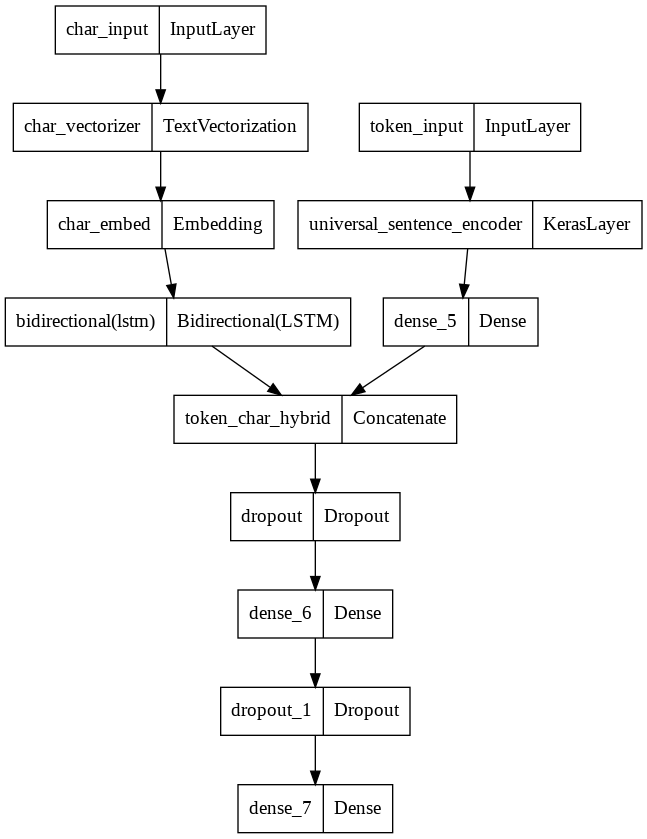

In [59]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [60]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [61]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>)

In [62]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/3
394/394 [==============================] - 14s 23ms/step - loss: 1.8068 - accuracy: 0.3197 - val_loss: 1.5935 - val_accuracy: 0.4171
Epoch 2/3
394/394 [==============================] - 8s 20ms/step - loss: 1.6036 - accuracy: 0.4148 - val_loss: 1.5423 - val_accuracy: 0.4293
Epoch 3/3
394/394 [==============================] - 8s 20ms/step - loss: 1.5566 - accuracy: 0.4370 - val_loss: 1.5321 - val_accuracy: 0.4307


In [63]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

44/44 [==============================] - 1s 13ms/step - loss: 1.5321 - accuracy: 0.4307


[1.5321462154388428, 0.43071427941322327]

In [64]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[0.29655156, 0.06567844, 0.09516336, ..., 0.2032194 , 0.07487907,
        0.15577017],
       [0.01619784, 0.0820227 , 0.00391679, ..., 0.00659014, 0.02786751,
        0.23829521],
       [0.02482343, 0.3915576 , 0.00575776, ..., 0.00219818, 0.01692913,
        0.3436322 ],
       ...,
       [0.2680585 , 0.02791974, 0.27257857, ..., 0.14915287, 0.09583282,
        0.08700029],
       [0.3488811 , 0.07440341, 0.05757969, ..., 0.20478863, 0.04597391,
        0.08129666],
       [0.5680169 , 0.02348103, 0.1732926 , ..., 0.05441438, 0.03432549,
        0.09151485]], dtype=float32)

In [65]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1) + 1
model_4_preds

<tf.Tensor: shape=(1400,), dtype=int64, numpy=array([1, 5, 2, ..., 3, 1, 1])>

In [66]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 43.07142857142857,
 'f1': 0.42076056233556886,
 'precision': 0.4241685466573883,
 'recall': 0.4307142857142857}

#### Model 5 - BERT (Incomplete)

In [107]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

text_test = ['this is such an amazing movie!']
text_test = [random.choice(train_sentences)]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2200 2785 1997 2017 1010 2720 1012 1031 2711]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [108]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.3062483   0.99894744 -0.03433928  0.38735658  0.23587288  0.9755268
  0.9729451  -0.99490714 -0.3410041  -0.9964887   0.18622637 -0.9883764 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 1.0614258  -0.19430915  0.10584182 ... -1.1835339   0.10871412
   0.8246153 ]
 [-0.2749042  -0.6102816  -0.02233105 ...  0.29334378 -0.52603847
   0.53293294]
 [-0.15126374  0.38260013 -0.6326646  ... -0.06808788 -0.46297383
  -0.32651198]
 ...
 [-0.6093906   0.12814163 -0.8175808  ... -1.3783449  -0.43278936
   0.06295902]
 [ 0.2995829   0.50764644 -0.16923082 ... -1.509382    0.09240741
   1.204099  ]
 [-0.29833755  0.02252938 -0.10963063 ... -0.7580279   0.43616018
   0.30763906]]


In [116]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = bert_preprocess_model(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="sigmoid")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(8, activation="softmax")(x) # create the output layer
model_5 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

ValueError: ignored

In [ ]:
# Fit feature extractor model for 3 epochs
model_5.fit(train_dataset,
            steps_per_epoch=int(len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(len(valid_dataset)))

In [ ]:
# Evaluate on whole validation dataset
model_5.evaluate(valid_dataset)

In [ ]:
# Make predictions with feature extraction model
model_5_pred_probs = model_5.predict(valid_dataset)
model_5_pred_probs

In [ ]:
# Convert the predictions with feature extraction model to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1) + 1
model_5_preds

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

### Compare model results

In [97]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,32.285714,0.493389,0.322857,0.259882
custom_token_embed_conv1d,35.928571,0.356116,0.359286,0.355036
pretrained_token_embed,44.071429,0.442109,0.440714,0.436624
custom_char_embed_conv1d,27.214286,0.270255,0.272143,0.220242
hybrid_char_token_embed,43.071429,0.424169,0.430714,0.420761


In [98]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

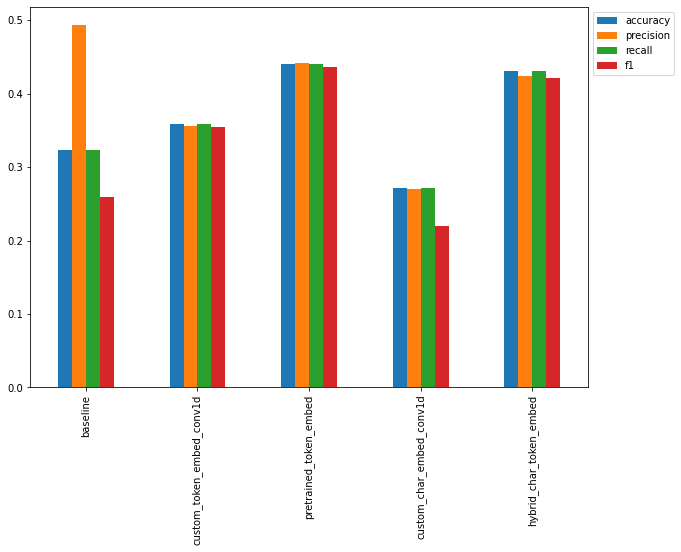

In [99]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

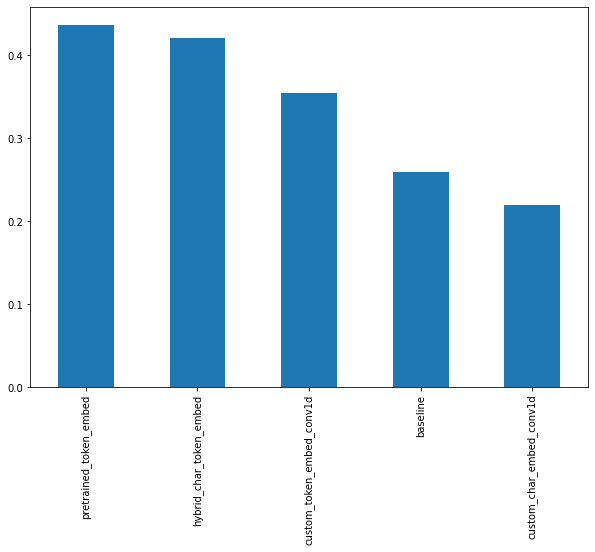

In [100]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));